# Grupo:

- Felipe Seppe <br>
- Luan Franco <br>
- Mateus Figueiredo

In [22]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import imread
from scipy.misc import imsave

import skimage
import skimage.transform as tf
from skimage import io
from skimage import filters
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

RED, GREEN, BLUE, BRIGHT = (0, 1, 2, 3)

In [20]:
def remove_green(img):
    '''
    objetivo: zerar o brilho dos pixels verdes do fundo.
    '''
    ratio = 255
    '''
    obter a intensidade de
    cada camada
    '''
    red = img[:,:,RED]/ratio
    green = img[:,:,GREEN]/ratio
    blue = img[:,:,BLUE]/ratio

    '''
    com isso, os pixels mais escuros estao proximos de 0
    para evitar remover os negativos pequenos, adicionamos uma
    constante pequena para torna-los positivos
    '''
    redxgreen = (red - green) + 0.55
    bluexgreen = (blue - green) + 0.55

    '''
    pixels menores que 0 são os verdes 
    do fundo que queremos remover
    '''
    redxgreen[redxgreen < 0] = 0
    bluexgreen[bluexgreen < 0] = 0

    '''
    combinar o red x green com o blue x green para gerar
    a nova camada de brilho com valores validos
    '''
    bright = (redxgreen + bluexgreen) * 255
    bright[bright > 75] = 255

    img[:,:,BRIGHT] = bright

    return img

'''
compoe as imagens com o fundo
pos = x,y inicial da img
scale = escalar para ampliar/reduzir a image
rotate = angulo que a imagem sera rotacionada
'''
def blend(bg, img, pos = (0,0), scale = None, rotate = None, reflect = None):

    treshhold = 150

    if(scale != None):
        img = tf.rescale(img, scale)
    if(rotate != None):
        img = tf.rotate(img, rotate)
    if(reflect != None):
        img = np.fliplr(img)

    x_ini = pos[0]
    y_ini = pos[1]

    x_fim = x_ini + img.shape[0]
    y_fim = y_ini + img.shape[1]

    if(x_fim > bg.shape[0]): # impedindo que x ou y ultrapassem o tamanho de bg
        x_fim = bg.shape[0]
    if(y_fim > bg.shape[1]):
        y_fim = bg.shape[1]

    img = skimage.img_as_ubyte(img)

    for i in range(x_ini, x_fim):
        for j in range(y_ini, y_fim):
            if(img[i-x_ini, j-y_ini, BRIGHT] > treshhold):
                bg[i][j][:] = img[i-x_ini][j-y_ini][:]
    return bg


def blurring(image):
    img = image.copy()
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]])
    mult = 1/16
    for i in range(3):
        img[:-2,:-2,i] = convolucao(img[:,:,i], kernel, mult)
    return img


def realce(image):
    img = image.copy()
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    for i in range(3):
        img[:-2,:-2,i] = convolucao(img[:,:,i], kernel)
    return img

def convolucao(image, kernel, mult=1):
    
    image_rows, image_cols = np.shape(image) # pegando a forma da matriz image
    kernel_rows, kernel_cols = np.shape(kernel) # pegando a forma do kernel
    
    # a nova matriz terá uma forma menor que a anterior com base no tamanho do kernel
    result = np.zeros((image_rows-(kernel_rows-1), image_cols-(kernel_cols-1)))
    
    # agora iremos iterar cada posicao da matriz result
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            # o valor de cada posicao i, j sera dado pela funcao np.sum
            # ela fará a soma da matriz top multiplicando um trecho da matriz image
            result[i][j] = np.sum(kernel * image[i:i+kernel_rows, j:j+kernel_cols]) * mult
    return result

In [30]:
# recebendo imagens a serem utilizadas

bg = imread("imgs/background.jpg", mode = 'RGBA')

c3po = imread("imgs/c3po.jpg", mode = 'RGBA')
falcon = imread("imgs/falcon.jpg", mode = 'RGBA')
galo = imread("imgs/galo1.jpg", mode = 'RGBA')
celular = imread("imgs/celular.jpg", mode = 'RGBA')
skate = imread("imgs/skate.jpg", mode = 'RGBA')
shark = imread("imgs/shark.jpg", mode = 'RGBA')
luan = imread("imgs/luan.png", mode = 'RGBA')
fight = imread("imgs/fight.jpeg", mode = 'RGBA')

remove_green(c3po)
remove_green(falcon)
remove_green(galo)
remove_green(celular)
remove_green(skate)
remove_green(shark)
remove_green(fight)

# aplicando o filtro blurring para diminuir problemas no fundo verde da iamgen 
luan = blurring(luan)
remove_green(luan)

print(bg.shape)

(1080, 1920, 4)


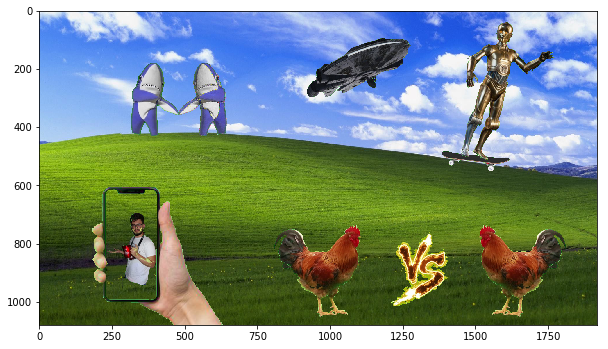

In [36]:
img = bg.copy()

# aplicando filtros (demora mto, melhor comentar quando testar as outras coisas)
shark2 = realce(shark)
c3po = blurring(c3po)

img = blend(img, celular, (500,-100), 2)
img = blend(img, luan, (690,230), 0.5)
img = blend(img, galo, (700,670), 0.8)
img = blend(img, galo, (700,1270), 0.8, reflect=1)
img = blend(img, fight, (740,1110), 0.6)
img = blend(img, skate, (405,1300), 0.3, 0)
img = blend(img, c3po, (-30,1100), 0.8, -17)
img = blend(img, falcon, (-30, 700), scale=0.6, rotate=200)
img = blend(img, shark, (150,100), 0.4, 0.2)
img = blend(img, shark2, (150,350), 0.4, 0.2, reflect=1)

imsave("outfile.png", img)

fig, ax = plt.subplots(1, 1)
ax.imshow(img)
fig.set_size_inches(10, 10)
plt.show(fig)